# Generalized Income Process

In [1]:
# Initial imports and notebook setup
from copy import copy

import matplotlib.pyplot as plt
import numpy as np

from HARK.utilities import plot_funcs

In [2]:
from HARK.ConsumptionSaving.ConsGenIncProcessModel import (
    IndShockExplicitPermIncConsumerType,
    PersistentShockConsumerType,
)
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

Recall that the `ConsIndShockModel` assumes that income has a permanent component $p$ which is subject to "permanent" shocks:

   $\log p_{t+1} = \log p_{t} + \log \psi_{t+1}$

However, many papers in the literature instead examine models in which shocks merely have some persistence,

$\log p_{t+1} = \varphi \log p_{t} + \log \psi_{t+1}$

where if $0 < \varphi < 1$ then $\lim_{n \uparrow \infty} \mathbb{E}_{t}[\log p_{t+n}]=0$ (which means that the level of $p$ reverts to its mean of $p=1$.  The two models become identical as $\varphi$ approaches 1.

This notebook describes HARK's tools to solve models with persistent shocks. This is acheived by the following:

1. Defining `GenIncProcessConsumerType`, which includes persistent income $P_t$ as a state variable, with a general or generic income process.
2. Defining the `IndShockExplicitPermIncConsumerType` as a special case of `GenIncProcessConsumerType`, which replicates `IndShockConsumerType`'s income process *but* explicitly tracks permanent income as a state variable.
3. Defining the `PersistentShockConsumerType` as another (more useful) special case of `GenIncProcessConsumerType` that includes an AR(1) persistent income process (in logs).

## General Income Process model
In the `ConsGenIncProcessModel`, the user can define a generic function $G$ that translates current $P_{t}$ into expected next period persistent income $P_{t+1}$ (subject to shocks).

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{c_t} U(c_t) + \beta \mathsf{S}_{t} \mathbb{E}_{t} [V_{t+1}(M_{t+1}, P_{t+1})] ~~\text{s.t.}\\
A_t &=& M_t - C_t, \\
A_t &\geq& \underline{a} \cdot P_t, \\
M_{t+1} &=& \mathsf{R}_{t+1} A_t + \theta_{t+1}, \\
P_{t+1} &=& G_{t+1}(P_t)\psi_{t+1}, \\
\psi_t \sim F_{\psi_t} &\qquad&  \theta_t \sim F_{\theta_t}, \\
\mathbb{E} [{\psi_t}] &=& 1, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}.
\end{eqnarray*}

The one-period problem for this model is solved by the function `solve_one_period_ConsGenIncProcess`. The class `GenIncProcessConsumerType` extends `IndShockConsumerType` to represent agents in this model. To construct an instance of this class, several  parameters must be passed to the constructor, as shown in the table below (parameters can be either "primitive" or "constructed").

### Example parameter values to solve GenIncProcess model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\beta$ |Intertemporal discount factor  | `DiscFac` | 0.96 | |
| $\rho$ |Coefficient of relative risk aversion | `CRRA` | 2.0 | |
| $\mathsf{R}_t$ | Risk free interest factor | `Rfree` | 1.03 | |
| $\mathsf{S}_t$ |Survival probability | `LivPrb` | [0.98] | |
| $\underline{a}$ |Artificial borrowing constraint | `BoroCnstArt` | 0.0 | |
| $(none)$ |Indicator for whether `vFunc` should be computed | `vFuncBool` | 'True' | |
| $(none)$ |Indicator for whether `cFunc` should use cubic splines | `CubicBool` | 'False' |  |
|$F$ |A list containing three arrays of floats, representing a discrete <br> approximation to the income process: <br>event probabilities, persistent shocks, transitory shocks | `IncomeDstn` | - |$\surd$ |
| $G$ |Expected persistent income next period | `pLvlNextFunc` | - | $\surd$ |
| $(none)$ |Array of time-varying persistent income levels | `pLvlGrid` | - |$\surd$ |
| $(none)$ | Array of "extra" end-of-period asset values | `aXtraGrid` | - |$\surd$ |

### Constructed inputs to solve GenIncProcess

The "constructed" inputs above are using expected attributes and use default constructor functions as follows.

* The input `IncomeDstn` is created by the function `construct_lognormal_income_process_unemployment`, the default income shock constructor for almost all HARK models.

* The input `pLvlNextFunc` is created by the function `make_trivial_pLvlNextFunc`. In this model, the default constructor creates a trivial `pLvlNextFunc` attribute with no persistent income dynamics.  But we can overwrite it manually or when defining other subclasses (for example, to make an AR1 income process for the newly defined agent-type).

* The input `pLvlGrid` is created by the function `make_pLvlGrid_by_simulation`, which is done by updating the grid of persistent income levels for infinite horizon models (cycles=0) and lifecycle models (cycles=1). This method draws on the initial distribution of persistent income, the `pLvlNextFunc`s, `pLogInitMean`, `pLogInitStd` and the attribute `pLvlPctiles` (percentiles of the distribution of persistent income). It then uses a simulation approach to generate the `pLvlGrid` at each period of the cycle.

* `pLvlPctiles` is itself constructed by `make_basic_pLvlPctiles` based on primitive parameters including `pLvlPctiles_count`, `pLvlPctiles_bound`, and `pLvlPctiles_tail_count`.

* The input `aXtraGrid` is created by `make_assets_grid`, which builds the agent's end-of-period assets grid by constructing a multi-exponentially spaced grid of aXtra values, based on `aXtraMin`, `aXtraMax`, `aXtraCount`, and `aXtraNestFac`.

## Consumer with Explicit Permanent Income

Now that we've defined the baseline model of a consumer facing persistent income shocks, we can define an "explicit permanent income" consumer who experiences idiosyncratic shocks to permanent and transitory, and faces permanent income growth *as a particular case of the general model*.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t} U(C_t) + \beta \mathsf{S}_{t} \mathbb{E} [V_{t+1}(M_{t+1}, P_{t+1}) ], \\
A_t &=& M_t - C_t, \\
A_t &\geq& \underline{a} \cdot P_t, \\
M_{t+1} &=& \mathsf{R}_{t+1} A_t + \theta_{t+1}, \\
P_{t+1} &=& G_{t+1}(P_t)\psi_{t+1}, \\
(\psi_t,\theta_t) &\sim& F_{t}, ~~\mathbb{E} [{\psi_t}] = 1, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}.
\end{eqnarray*}


**NB:** This agent type is identical to an `IndShockConsumerType` consumer, but now the level of permanent income `pLvl` is explicitly tracked as a state variable. This is the sense in which this model is a particular class of the GenIncProcess model, as shown in the mathematical description of the agent's optimization problem in that model.

To construct `IndShockExplicitPermIncConsumerType`, we need to pass additional parameters to the constructor as shown in the table below.

### Additional parameters to solve ExplicitPermInc model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
|$\Gamma$ | Permanent income growth factor| `PermGroFac` | [1.0]| |

### Constructed inputs to solve ExplicitPermInc

* In this "explicit permanent income" model, we replace the constructor for `pLvlNextFunc` with `make_explicit_perminc_pLvlNextFunc` to create `pLvlNextFunc` as a sequence of linear functions, indicating constant expected permanent income growth across permanent income levels.  This method uses the attribute `PermGroFac`.

In [3]:
# This cell defines a dictionary to make an instance of "explicit permanent income" consumer.
GenIncDictionary = {
    "CRRA": 2.0,  # Coefficient of relative risk aversion
    "Rfree": [1.03],  # Interest factor on assets
    "DiscFac": 0.96,  # Intertemporal discount factor
    "LivPrb": [0.98],  # Survival probability
    "AgentCount": 10000,  # Number of agents of this type (only matters for simulation)
    "kLogInitMean": 0.0,  # Mean of log initial assets (only matters for simulation)
    "kLogInitStd": 1.0,  # Standard deviation of log initial assets (only for simulation)
    "pLogInitMean": 0.0,  # Mean of log initial permanent income (only matters for simulation)
    "pLogInitStd": 0.0,  # Standard deviation of log initial permanent income (only matters for simulation)
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor (only matters for simulation)
    "T_age": None,  # Age after which simulated agents are automatically killed
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 30,  # Maximum end-of-period "assets above minimum" value
    # Some other value of "assets above minimum" to add to the grid
    "aXtraExtra": np.array([0.005, 0.01]),
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount": 48,  # Number of points in the grid of "assets above minimum"
    # Parameters describing the income process
    "PermShkCount": 7,  # Number of points in discrete approximation to permanent income shocks
    "TranShkCount": 7,  # Number of points in discrete approximation to transitory income shocks
    "PermShkStd": [0.1],  # Standard deviation of log permanent income shocks
    "TranShkStd": [0.1],  # Standard deviation of log transitory income shocks
    "UnempPrb": 0.05,  # Probability of unemployment while working
    "UnempPrbRet": 0.005,  # Probability of "unemployment" while retired
    "IncUnemp": 0.3,  # Unemployment benefits replacement rate
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "tax_rate": 0.0,  # Flat income tax rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "CubicBool": False,  # Use cubic spline interpolation when True, linear interpolation when False
    "vFuncBool": True,  # Whether to calculate the value function during solution
    # More parameters specific to "Explicit Permanent income" shock model
    "cycles": 0,
    "pLvlPctiles": np.concatenate(
        (
            [0.001, 0.005, 0.01, 0.03],
            np.linspace(0.05, 0.95, num=19),
            [0.97, 0.99, 0.995, 0.999],
        ),
    ),
    "PermGroFac": [
        1.0,
    ],  # Permanent income growth factor - long run permanent income growth doesn't work yet
}

Let's now create an instance of the type of consumer we are interested in and solve this agent's problem with an infinite horizon (cycles=0).

In [4]:
# Make and solve an example "explicit permanent income" consumer with idiosyncratic shocks
ExplicitExample = IndShockExplicitPermIncConsumerType(**GenIncDictionary)

print("Here, the lowest percentile is " + str(GenIncDictionary["pLvlPctiles"][0] * 100))
print(
    "and the highest percentile is "
    + str(GenIncDictionary["pLvlPctiles"][-1] * 100)
    + ".\n",
)

ExplicitExample.solve()

Here, the lowest percentile is 0.1
and the highest percentile is 99.9.



In the cell below, we generate a plot of the consumption function for explicit permanent income consumer at different income levels.

Consumption function by pLvl for explicit permanent income consumer:


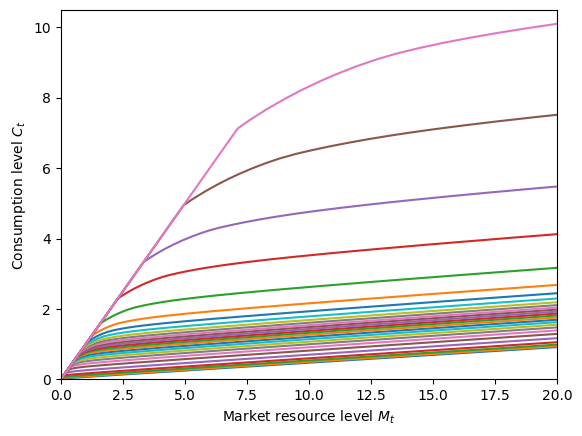

In [5]:
# Plot the consumption function at various permanent income levels.
print("Consumption function by pLvl for explicit permanent income consumer:")
pLvlGrid = ExplicitExample.pLvlGrid[0]
mLvlGrid = np.linspace(0, 20, 300)
for p in pLvlGrid:
    M_temp = mLvlGrid + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp, p * np.ones_like(M_temp))
    plt.plot(M_temp, C)
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 10.5)
plt.xlabel(r"Market resource level $M_t$")
plt.ylabel(r"Consumption level $C_t$")
plt.show()

## Permanent income normalized

For comparison, we can solve the same problem much faster using an `IndShockConsumerType`, which normalizes out permanent income $P_t$ when solving the model. That is, the model's solution is homothetic with respect to permanent income, so the `ExplicitPermInc` model is *intentionally* doing much more work than needed to solve the model.

Let's solve an equivalent problem with `IndShockConsumerType` and then compare the *normalized* solutions.

In [6]:
# Make and solve an example of normalized model
NormalizedExample = IndShockConsumerType(**GenIncDictionary)
NormalizedExample.solve()

Normalized consumption function by pLvl for explicit permanent income consumer:


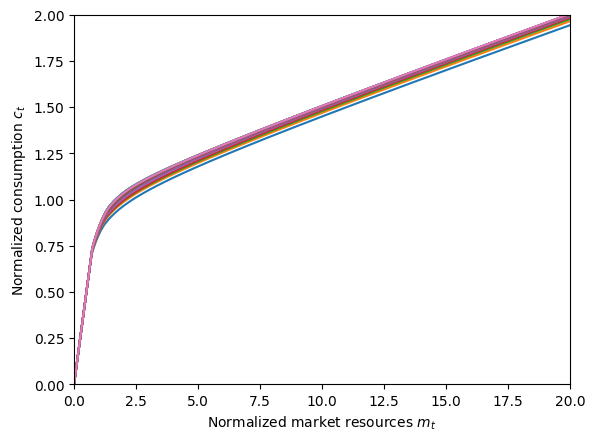

Consumption function for normalized problem (without explicit permanent income):


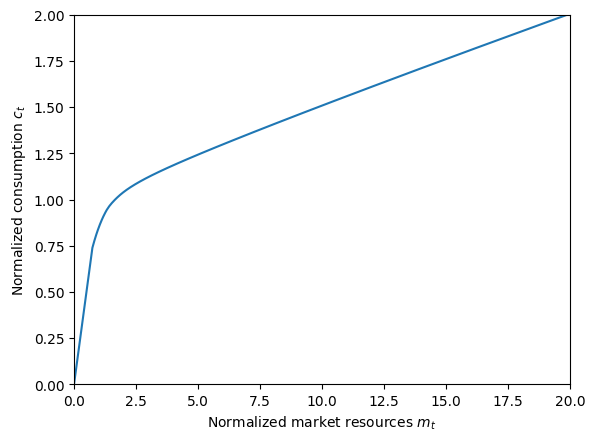

In [7]:
# Compare the normalized problem with and without explicit permanent income and plot the consumption functions
print("Normalized consumption function by pLvl for explicit permanent income consumer:")
pLvlGrid = ExplicitExample.pLvlGrid[0]
mNrmGrid = np.linspace(0, 20, 300)
for p in pLvlGrid:
    M_temp = mNrmGrid * p + ExplicitExample.solution[0].mLvlMin(p)
    C = ExplicitExample.solution[0].cFunc(M_temp, p * np.ones_like(M_temp))
    plt.plot(M_temp / p, C / p)

plt.xlim(0.0, 20.0)
plt.ylim(0.0, 2.0)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plt.show()

print(
    "Consumption function for normalized problem (without explicit permanent income):",
)
mNrmMin = NormalizedExample.solution[0].mNrmMin
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 2.0)
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_funcs(NormalizedExample.solution[0].cFunc, mNrmMin, mNrmMin + 20.0)

The figures above show that the normalized consumption function for the "explicit permanent income" consumer is almost identical for every permanent income level (and the same as the normalized problem's `cFunc`), but is less accurate due to extrapolation outside the bounds of`pLvlGrid`.

The "explicit permanent income" solution deviates from the solution to the normalized problem because of errors from extrapolating beyond the bounds of the `pLvlGrid`. The error is largest for $P_t$ values near the upper and lower bounds, and propagates toward the center of the distribution.

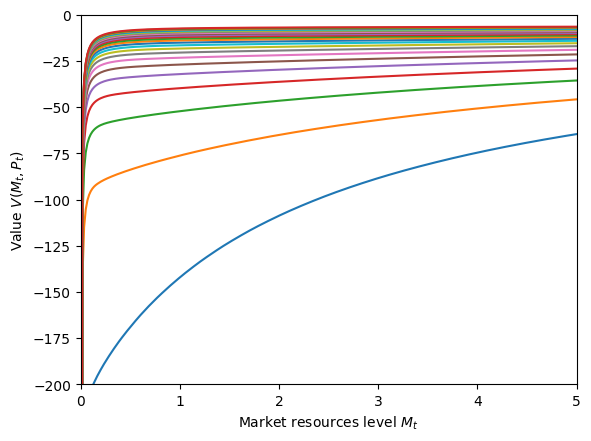

In [8]:
# Plot the value function at various permanent income levels
if ExplicitExample.vFuncBool:
    pGrid = np.linspace(0.1, 3.0, 24)
    M = np.linspace(0.001, 5, 300)
    for p in pGrid:
        M_temp = M + ExplicitExample.solution[0].mLvlMin(p)
        C = ExplicitExample.solution[0].vFunc(M_temp, p * np.ones_like(M_temp))
        plt.plot(M_temp, C)
    plt.ylim([-200, 0])
    plt.xlim(0.0, 5.0)
    plt.xlabel(r"Market resources level $M_t$")
    plt.ylabel(r"Value $V(M_t,P_t)$")
    plt.show()

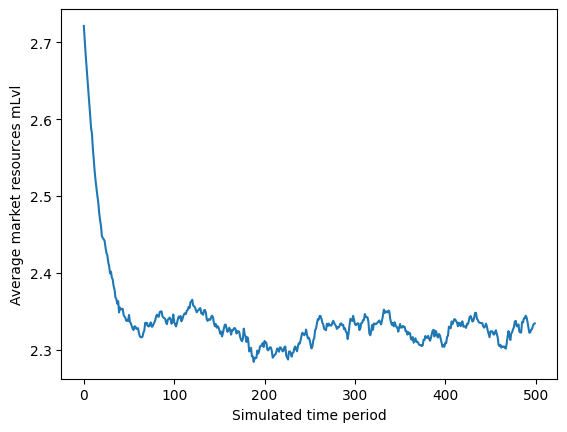

In [9]:
# Simulate many periods to get to the stationary distribution
ExplicitExample.T_sim = 500
ExplicitExample.track_vars = ["mLvl", "cLvl", "pLvl"]
ExplicitExample.initialize_sim()
ExplicitExample.simulate()
plt.plot(np.mean(ExplicitExample.history["mLvl"], axis=1))
plt.xlabel("Simulated time period")
plt.ylabel("Average market resources mLvl")
plt.show()

## Persistent income shock consumer


Next, the `PersistentShockConsumerType` class is introduced to solve consumption-saving models with idiosyncratic shocks to income in which shocks are persistent and transitory. This model extends `ConsGenIndShockModel` by allowing (log) persistent income to follow an AR(1) process.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
V_t(M_t,P_t) &=& \max_{C_t} U(C_t) + \beta \mathsf{S}_{t} \mathbb{E} [V_{t+1}(M_{t+1}, P_{t+1}) ], \\
A_t &=& M_t - C_t, \\
A_t &\geq& \underline{a} \cdot P_t, \\
M_{t+1} &=& \mathsf{R}_{t+1} A_t + \theta_{t+1}, \\
\log(P_{t+1}) &=& \varphi \log(P_t)+(1-\varphi) \log(\overline{P}_{t+1}) + \log(\Gamma_{t+1}) + \log(\psi_{t+1}), \\
(\psi_t, \theta_t) &\sim& F_{t}, \\
\mathbb{E} [{\psi_t}] &=& 1, \\
U(C) &=& \frac{C^{1-\rho}}{1-\rho}.
\end{eqnarray*}

The sequence of $\overline{P}_{t}$ depends on the cumulative product of $\Gamma_t$ up to age $t$, starting from some initial level $\overline{P}_0$.

### Additional example parameters to solve PersistentShock model

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
|$\varphi$|Serial correlation coefficient for permanent income| `PrstIncCorr` |0.98||
||||||

### Constructed inputs to solve PersistentShock

For this model, we swap the constructor for `pLvlNextFunc` to the function ` make_AR1_style_pLvlNextFunc`, which builds a sequence of AR1-style functions. This function now the attributes `PermGroFac` and `PrstIncCorr`, along with `pLogInitMean`. If `cycles=0`, the product of `PermGroFac` across all periods must be 1.0, otherwise this method is invalid.

In [10]:
# Make a dictionary for the "persistent idiosyncratic shocks" model
PrstIncCorr = 0.98  # Serial correlation coefficient for persistent income

persistent_shocks = copy(GenIncDictionary)
persistent_shocks["PrstIncCorr"] = PrstIncCorr

The `PersistentShockConsumerType` class solves the problem of a consumer facing idiosyncratic shocks to his persistent and transitory income, and for which the (log) persistent income follows an AR1 process rather than random walk. After modifying the dictionary from the `ConsGenIncProcessModel` class to accomodate these modeling choices, we generate a particular instance of the "persistent income" consumer type below.

In [11]:
# Make and solve an example of "persistent idisyncratic shocks" consumer
PersistentExample = PersistentShockConsumerType(**persistent_shocks)
PersistentExample.solve()

Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of 0.98:


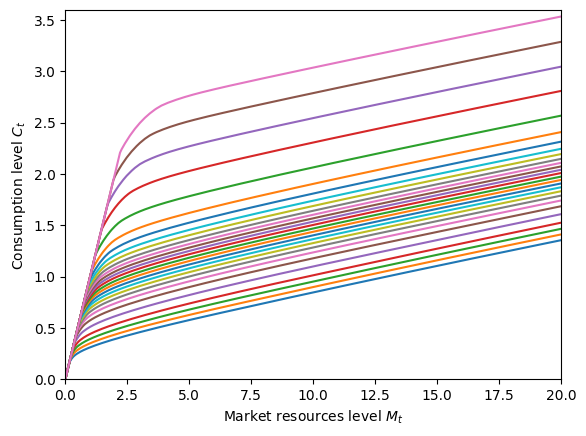

In [12]:
# Plot the consumption function at various levels of persistent income pLvl
print(
    "Consumption function by persistent income level pLvl for a consumer with AR1 coefficient of "
    + str(PersistentExample.PrstIncCorr)
    + ":",
)
pLvlGrid = PersistentExample.pLvlGrid[0]
mLvlGrid = np.linspace(0, 20, 300)
for p in pLvlGrid:
    M_temp = mLvlGrid + PersistentExample.solution[0].mLvlMin(p)
    C = PersistentExample.solution[0].cFunc(M_temp, p * np.ones_like(M_temp))
    plt.plot(M_temp, C)
plt.xlim(0.0, 20.0)
plt.ylim(0.0, 3.6)
plt.xlabel(r"Market resources level $M_t$")
plt.ylabel(r"Consumption level $C_t$")
plt.show()

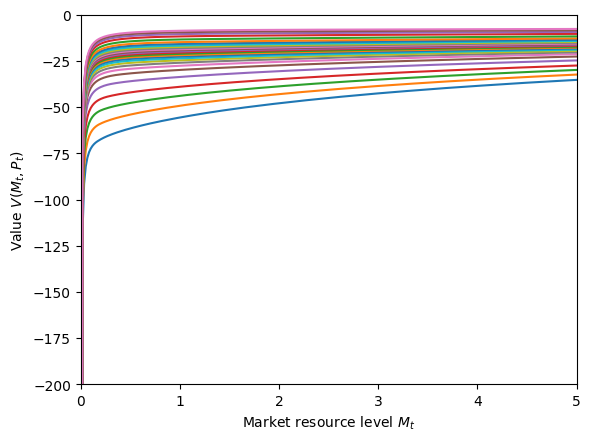

In [13]:
# Plot the value function at various persistent income levels
if PersistentExample.vFuncBool:
    pGrid = PersistentExample.pLvlGrid[0]
    M = np.linspace(0.001, 5, 300)
    for p in pGrid:
        M_temp = M + PersistentExample.solution[0].mLvlMin(p)
        C = PersistentExample.solution[0].vFunc(M_temp, p * np.ones_like(M_temp))
        plt.plot(M_temp, C)
    plt.ylim([-200, 0])
    plt.xlim(0.0, 5.0)
    plt.xlabel(r"Market resource level $M_t$")
    plt.ylabel(r"Value $V(M_t,P_t)$")
    plt.show()

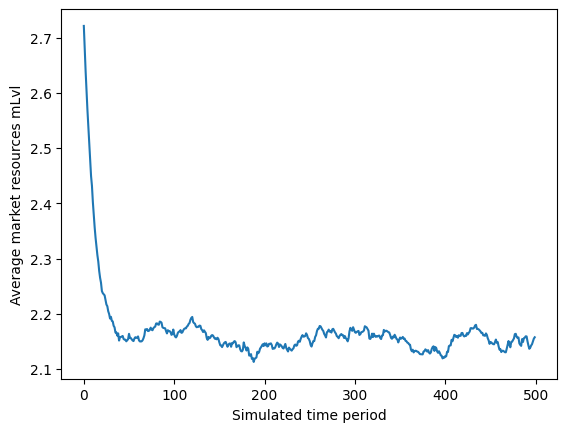

In [14]:
# Simulate some data
PersistentExample.T_sim = 500
PersistentExample.track_vars = ["mLvl", "cLvl", "pLvl"]
PersistentExample.initialize_sim()
PersistentExample.simulate()
plt.plot(np.mean(PersistentExample.history["mLvl"], axis=1))
plt.xlabel("Simulated time period")
plt.ylabel("Average market resources mLvl")
plt.show()